### Module 7 Wrap-up quiz

In [1]:
import pandas as pd

cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000
...,...,...,...,...,...
2020-09-13 14:55:57,130.0,0.0,1.054,0.0234,0.000000
2020-09-13 14:55:58,130.0,0.0,0.829,0.0258,0.000000
2020-09-13 14:55:59,129.0,0.0,0.616,-0.1686,0.000000


In [2]:
import numpy as np
data_new = data.drop(columns={"heart-rate", "cadence"}) # drop unused columns
data_new["acceleration"].clip(lower=0, inplace=True) # remove negative acceleration and replace with 0
# data_new["acceleration"].describe()

In [3]:
import numpy as np
data_q1 = pd.DataFrame({"cube-speed": np.power(data_new["speed"], 3), # cube of speed
                        "speed": data_new["speed"], # original speed
                        "speed-sine-slope": np.sin(np.arctan(data_new["slope"])) * data_new["speed"], # speed times the sine of the slope 
                        "speed-accel": data_new["speed"] * data_new["acceleration"]} # speed multiplied by acceleration
                        )
data_q1 # new dataframe for the predictive model

,cube-speed,speed,speed-sine-slope,speed-accel
,,,,
2020-08-18 14:43:19,80.901828,4.325,-0.146402,0.380600
2020-08-18 14:43:20,81.520685,4.336,-0.145482,0.365091
2020-08-18 14:43:21,85.707790,4.409,-0.146398,0.103171
2020-08-18 14:43:22,87.824421,4.445,-0.146198,0.007112
2020-08-18 14:43:23,87.587538,4.441,0.000000,0.508050
...,...,...,...,...
2020-09-13 14:55:57,1.170905,1.054,0.000000,0.024664
2020-09-13 14:55:58,0.569723,0.829,0.000000,0.021388
2020-09-13 14:55:59,0.233745,0.616,0.000000,0.000000


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from helpers.myfunctions import plot_pipe

scaler = StandardScaler()
model = RidgeCV()
pipe = make_pipeline(scaler, model)
plot_pipe()
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

### Question 1

In [5]:
data_q1["speed-sine-slope"].mean()

-0.002709709612566326

In [6]:
from sklearn.model_selection import cross_validate
cv = ShuffleSplit(n_splits=4, random_state=0)
results = cross_validate(pipe, data_q1, target, scoring="neg_mean_absolute_error", return_estimator=True, return_train_score=True)

In [7]:
results['test_score'].mean()

-73.4952387827653

In [8]:
model_first_fold = results["estimator"][0]
feature_names = model_first_fold[0].get_feature_names_out(
    input_features=data_q1.columns)
feature_names
coefs = [est[-1].coef_ for est in results["estimator"]]
weights = pd.DataFrame(coefs, columns=feature_names)
weights

,cube-speed,speed,speed-sine-slope,speed-accel
0,2.876230,37.229313,81.437145,11.635639
1,10.338625,27.524391,81.321672,7.168709
2,5.602097,34.009784,81.048123,11.017244
3,3.410583,33.699435,76.863534,8.821816
4,4.602336,30.612378,80.882417,17.268430


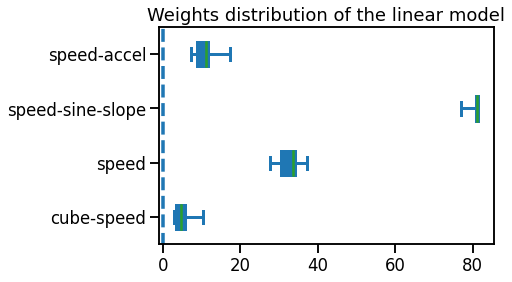

In [9]:
import matplotlib.pyplot as plt
ax = weights.plot.box(vert=False)
ax.axvline(0, -1, 1, linestyle="--")
_ = plt.title("Weights distribution of the linear model")

In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor
model_hist = HistGradientBoostingRegressor(max_iter=1_000, early_stopping=True, random_state=42)
# pipe_ensamble = make_pipeline(StandardScaler(), model_hist)
# pipe_ensamble

In [11]:
results_hist = cross_validate(model_hist, data, target, cv=cv, 
                    scoring="neg_mean_absolute_error", 
                    return_estimator=True,
                    return_train_score=True)
errors_hist = -results_hist['test_score']
print(f"Mean Absolute Error for HistGradientBoostingRegressor: {errors_hist.mean():.3f} +/- {errors_hist.std():.3f}")

Mean Absolute Error for HistGradientBoostingRegressor: 43.836 +/- 0.502


In [12]:
errors_hist = -results_hist['test_score']
errors_hist_train = -results_hist['train_score']
print(f"Mean Absolute Error for HistGradientBoostingRegressor test scores: {errors_hist.mean():.3f} +/- {errors_hist.std():.3f} \n"
        f"Mean Absolute Error for HistGradientBoostingRegressor train scores: {errors_hist_train.mean():.3f} +/- {errors_hist_train.std():.3f}")

Mean Absolute Error for HistGradientBoostingRegressor test scores: 43.836 +/- 0.502 
Mean Absolute Error for HistGradientBoostingRegressor train scores: 40.561 +/- 0.686


In [13]:
errors_linear = -results['test_score']
errors_linear_train = -results['train_score']
print(f"Mean Absolute Error for Lineair model test scores: {errors_linear.mean():.3f} +/- {errors_linear.std():.3f} \n"
        f"Mean Absolute Error for Linear model train scores: {errors_linear_train.mean():.3f} +/- {errors_linear_train.std():.3f}")

Mean Absolute Error for Lineair model test scores: 73.495 +/- 7.371 
Mean Absolute Error for Linear model train scores: 72.359 +/- 2.160


In [14]:
data.head()

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000


In [15]:
all_dates = data.index.date

In [16]:
print(f" There are {len(np.unique(data.index.date))} different dates in the dataset")

 There are 4 different dates in the dataset


In [17]:
#data['group'] = 
group, uniqes = pd.factorize(data.index.date)
group

array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

In [18]:
uniqes

array([datetime.date(2020, 8, 18), datetime.date(2020, 8, 20),
       datetime.date(2020, 8, 26), datetime.date(2020, 9, 13)],
      dtype=object)

In [39]:
data['group'] = group
data.head()

,heart-rate,cadence,speed,acceleration,slope,group
,,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870,0
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571,0
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223,0
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908,0
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000,0


In [40]:
data.drop(columns='group')

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000
...,...,...,...,...,...
2020-09-13 14:55:57,130.0,0.0,1.054,0.0234,0.000000
2020-09-13 14:55:58,130.0,0.0,0.829,0.0258,0.000000
2020-09-13 14:55:59,129.0,0.0,0.616,-0.1686,0.000000


In [43]:
from sklearn.model_selection import LeaveOneGroupOut
cv=LeaveOneGroupOut()
results_hist_leaveone = cross_validate(model_hist, data, target, cv=cv, groups=group, # using full data
                    scoring="neg_mean_absolute_error", 
                    return_estimator=True,
                    return_train_score=True,
                    n_jobs=2)

In [44]:
errors_hist_leaveone_train = -results_hist_leaveone['train_score']
errors_hist_leaveone_test = -results_hist_leaveone['test_score']
print(f"Mean Absolute Error for HistGradientBoostingRegressor - Leaveoneout test scores: {errors_hist_leaveone_test.mean():.3f} +/- {errors_hist_leaveone_test.std():.3f} \n"
        f"Mean Absolute Error for HistGradientBoostingRegressor  - Leaveoneout train scores: {errors_hist_leaveone_train.mean():.3f} +/- {errors_hist_leaveone_train.std():.3f}")

Mean Absolute Error for HistGradientBoostingRegressor - Leaveoneout test scores: 51.978 +/- 3.823 
Mean Absolute Error for HistGradientBoostingRegressor  - Leaveoneout train scores: 37.762 +/- 0.958


In [37]:
results_lin_leaveone = cross_validate(pipe, data_q1, target, cv=cv, groups=group, # using only formula data
                    scoring="neg_mean_absolute_error",
                    return_estimator=True, 
                    return_train_score=True)

In [38]:
errors_lin_leaveone_train = -results_lin_leaveone['train_score']
errors_lin_leaveone_test = -results_lin_leaveone['test_score']
print(f"Mean Absolute Error for Linear model - Leaveoneout test scores: {errors_lin_leaveone_test.mean():.3f} +/- {errors_lin_leaveone_test.std():.3f} \n"
        f"Mean Absolute Error for Linear model - Leaveoneout train scores: {errors_lin_leaveone_train.mean():.3f} +/- {errors_lin_leaveone_train.std():.3f}")

Mean Absolute Error for Linear model - Leaveoneout test scores: 73.015 +/- 5.779 
Mean Absolute Error for Linear model - Leaveoneout train scores: 72.249 +/- 2.247


In [45]:
print(f"LOGO has a difference in test error with ShuffleSplit of \n"
    f"LOGO: {errors_lin_leaveone_test.mean():.3f}, SHPLT: {errors_linear.mean():.3f} gives a difference of \n"
    f"{errors_lin_leaveone_test.mean() - errors_linear.mean():.3f}")

LOGO has a difference in test error with ShuffleSplit of 
LOGO: 73.015, SHPLT: 73.495 gives a difference of 
-0.480


In [46]:
print(f"LOGO has a difference in test error with ShuffleSplit of \n"
    f"LOGO: {errors_hist_leaveone_test.mean():.3f}, SHPLT: {errors_hist.mean():.3f} gives a difference of \n"
    f"{errors_hist_leaveone_test.mean() - errors_hist.mean():.3f}")

LOGO has a difference in test error with ShuffleSplit of 
LOGO: 51.978, SHPLT: 43.836 gives a difference of 
8.142


In [47]:
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=group))[0]

data_linear_model_train = data_q1.iloc[train_indices]
data_linear_model_test = data_q1.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

In [48]:
pipe.fit(data_linear_model_train, target_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

In [49]:
prediction = pipe.predict(data_linear_model_test)

In [50]:
prediction

array([ 93.42223143,  93.75052407,  92.49489593, ..., 107.06972315,
       113.13215418, 108.00975246])

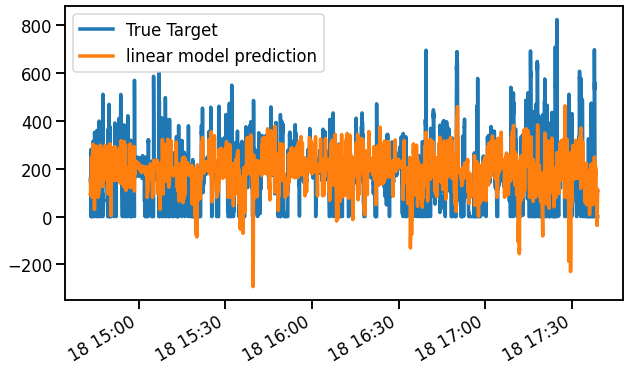

In [61]:
ax = target_test.plot(label='True Target', figsize=(10,6))
ax.plot(target_test.index, prediction, label='linear model prediction')
plt.legend()

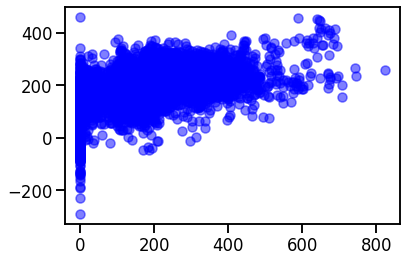

In [63]:
plt.scatter(target_test, prediction, alpha=0.5, c='blue')

In [64]:
model_hist.fit(data_train, target_train)
predict_hist = model_hist.predict(data_test)

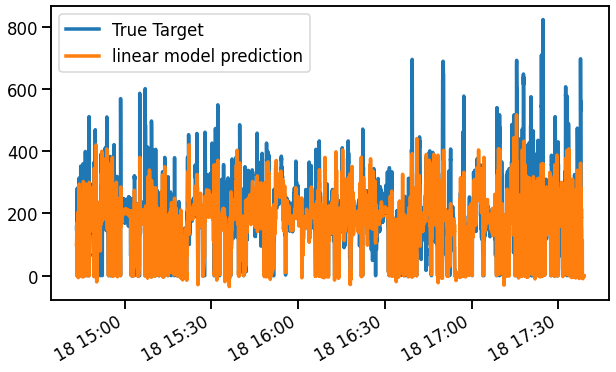

In [65]:
ax = target_test.plot(label='True Target', figsize=(10,6))
ax.plot(target_test.index, predict_hist, label='linear model prediction')
plt.legend()

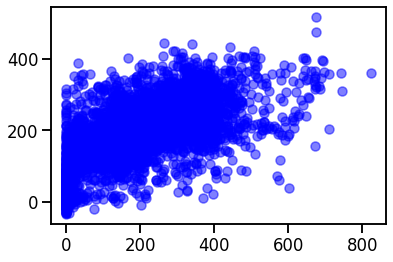

In [66]:
plt.scatter(target_test, predict_hist, alpha=0.5, c='blue')